In [0]:
import numpy as np
import os
import cv2
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib
import time

from IPython import display
import PIL
import imageio

import matplotlib.pyplot as plt

tfk = tf.keras
tfpl= tfp.layers
tfd = tfp.distributions

print("Tensorflow {}".format(tf.__version__))
print("TFP {}".format(tfp.__version__))

%matplotlib inline

TensorFlow 2.x selected.
Tensorflow 2.0.0-rc0
TFP 0.7.0


In [0]:
from google.colab import files
uploaded = files.upload()

Saving cloud_train_data.zip to cloud_train_data.zip


In [0]:
!unzip cloud_train_data.zip

Archive:  cloud_train_data.zip
  inflating: cloud_train_data.npy    


In [0]:
cloud_train_data = np.load("cloud_train_data.npy", allow_pickle=True)

In [0]:
# train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
# train_df["Label"] = train_df["Image_Label"].apply(lambda x: x.split('_')[1])
# train_df["Image"] = train_df["Image_Label"].apply(lambda x: x.split('_')[0])
# # train_df = train_df.drop(["Image_Label"], axis=1)

# train_imgs = os.path.join(data_path, "train_images")
# train = train_df
# train["label_cat"] = pd.Categorical(train.Label).codes
# # train[train]

In [0]:
input_shape = 126*126 + 4; print(input_shape)
z = 64
x_train, x_test = train_test_split(cloud_train_data, test_size=0.33)
x_train = [tf.tuple((tf.convert_to_tensor(x_train[i][0]),
                       tf.convert_to_tensor(x_train[i][1])))
                        for i in range(len(x_train))]

x_test = [tf.tuple((tf.convert_to_tensor(x_test[i][0]),
                       tf.convert_to_tensor(x_test[i][1])))
                        for i in range(len(x_test))]

15880


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, z):
    super(Encoder, self).__init__()
    self.latent_dim = z

    self.conv1 = tfk.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2,2), activation="relu")
    self.conv2 = tfk.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2,2), activation="relu")
    self.flatten = tfk.layers.Flatten()
    self.linear1 = tfk.layers.Dense(self.latent_dim, activation="relu")
    self.linear2 = tfk.layers.Dense(self.latent_dim + self.latent_dim)

  def call(self, x):
    # x0 = tf.expand_dims(tf.reshape(x[0],[-1]), 0)
    x0 = x[0]
    x1 = tf.expand_dims(x[1], 0)
    y = self.conv1(x0)
    y = self.conv2(y)
    y = self.flatten(y)
    k = self.linear1(x1)
    ky = (tf.concat((y, k), -1))
    y = self.linear2(ky)
    return y

class CVAE(tf.keras.Model):
    def __init__(self, z):
        super(CVAE, self).__init__()
        self.latent_dim = z
        
        self.encoder = Encoder(z)
        self.decoder = tfk.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(2,2), padding="SAME"),
        ])


    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

In [0]:
optimizer = tf.keras.optimizers.Nadam()

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
    -0.5 * ((sample - mean)**2.0 * tf.exp(-logvar) + logvar + log2pi),
    axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,
                                                       labels=x[0])
    logpx_z = - tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return - tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [0]:
epochs = 20
z = 256
num_examples = 16

random_gen_vector = tf.random.normal(
    shape=[num_examples, z])

model = CVAE(z)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 12, Test set ELBO: -3296.63671875, time elapse for current epoch 455.70837903022766


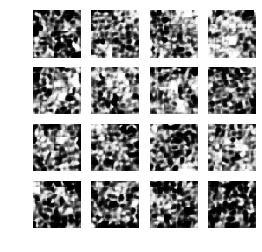

In [0]:
generate_and_save_images(model, 0, random_gen_vector)
import time
epochs = 50
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in x_train:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in x_test:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_gen_vector)
    
print("done")

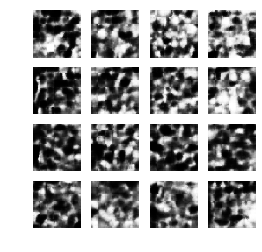

In [0]:
random_gen_vector = tf.random.normal(
    shape=[num_examples, z])
generate_and_save_images(model, -1, random_gen_vector)

In [0]:
ms = []
sds = []
lbls = []
for i in range(20):
    k = model.encode(x_test[i])
    ms.append(k[0].numpy())
    sds.append(k[1].numpy())
    lbls.append(np.argmax(x_test[i][1]))

means = np.squeeze(np.hstack(ms))
stds = np.squeeze(np.hstack(sds))
ls = np.repeat(np.hstack(lbls), z)

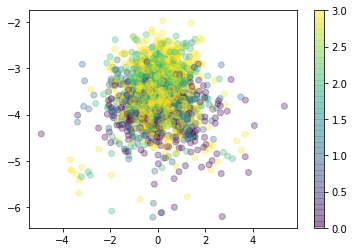

In [0]:
plt.scatter(means, stds, c=ls, alpha=0.3)
plt.colorbar()

In [0]:
model.save_weights('modelus')

In [0]:
!ls

checkpoint		 image_at_epoch_0009.png  image_at_epoch_0020.png
cloud_train_data.npy	 image_at_epoch_0010.png  image_at_epoch_0021.png
cloud_train_data.zip	 image_at_epoch_0011.png  image_at_epoch_0022.png
image_at_epoch_0000.png  image_at_epoch_0012.png  image_at_epoch_0023.png
image_at_epoch_0001.png  image_at_epoch_0013.png  image_at_epoch_0024.png
image_at_epoch_0002.png  image_at_epoch_0014.png  image_at_epoch_0025.png
image_at_epoch_0003.png  image_at_epoch_0015.png  image_at_epoch_0026.png
image_at_epoch_0004.png  image_at_epoch_0016.png  model.tar.gz
image_at_epoch_0005.png  image_at_epoch_0017.png  sample_data
image_at_epoch_0006.png  image_at_epoch_0018.png  saved_model
image_at_epoch_0007.png  image_at_epoch_0019.png
image_at_epoch_0008.png  image_at_epoch_-001.png


In [0]:
!mkdir saved_model

In [0]:
!mv modelus.* saved_model

In [0]:
!tar -czvf model.tar.gz saved_model/

saved_model/
saved_model/modelus.data-00001-of-00002
saved_model/modelus.data-00000-of-00002
saved_model/modelus.index


In [0]:
files.download('model.tar.gz')